# SA-OT Model (With Iterated Learning) of Jespersen's Cycle - A Replication of Lopopolo & Biro (2011)

## Model Overview
SA-OT (Simulated Annealing for Optimality Theory) extends classical Optimality Theory (OT) -- a model of linguistic competence -- by integrating a stochastic search algorithm that models linguistic performance. 
As such, it relies on the basic components of standard OT:
- a **candidate set** of linguistic forms, and
- a set of **constraints**, ranked into **hierarchies** that represent different grammars.

In addition, it introduces two new elements that allows modeling performance variation:
- a **neighborhood structure (topology)** that organizes the candidate set by structural similarity, and
- a **search algorithm** -- specifically, simulated annealing -- that performs a random walk through this candidate space, guided by a harmony function derived from the constraint hierarchy.

Since the search is stochastic, SA-OT does not always find the globally optimal candidate, i.e., the grammartical form. Instead, it might settle on local optima -- suboptimal outputs, e.g., errors arising from fast speech, slips of the tongue, or tolerable irregularities. This is how SA-OT models linguistic performance, not just idealized grammatical competence thus accounts for linguistic variation and change. 

# Model Components & Setup

## Libraries & Global Variables

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Candidates & Topology

A **candidate** is a pair of underlying form and surface form (uf, sf):
- **uf**: represents the semantics, i.e., the polarity of the utterance -- *positive* or *negative*; 
- **sf**: a *binary syntactic tree*, composed of a main verb (V) and zero or more sentential negation markers (SN). 

Note: We are only interested in negative uf.

In [3]:
# ----- Utility functions for formatting candidates -----
def flatten_singletons(x):
    """Recursively flatten singleton lists, including nested ones.
    Examples:
        [['V']]           -> 'V'
        ['SN', ['V']]     -> ['SN', 'V']
        [[['SN']], [['V']]] -> ['SN', 'V']
    
    Used in neighborhood generation where we want to 
    remove unnecessary bracketing around singleton lists,
    without flattening the whole structure.  
    """
    # Flatten the top level if it's a singleton list
    while isinstance(x, list) and len(x) == 1:
        x = x[0]

    # If it's still a list, apply recursively to each element
    if isinstance(x, list):
        return [flatten_singletons(elem) for elem in x]
    
    # If it's not a list, return as is
    else:
        return x

def flatten_sf(sf):
    """Utility to flatten nested list trees using recursion.
    
    Args:
        sf (list or str): The surface form, which can be a nested list or the 'V' string.

    Returns:
        list: A flat list of surface form string elements.
    
    
    Used in constraint evaluation as candidate surface forms with the same linear structure
    are assigned the same number of violation marks by all constraints. 
    """
    if isinstance(sf, str):
        return [sf]
    elif isinstance(sf, list):
        return [item for sublist in sf for item in flatten_sf(sublist)]
    else:
        return []

def serialize_sf(sf, flat=False):
    """Recursively convert nested lists to string with bracketed nested or linear structure."""
    sf = flatten_singletons(sf)  # Flatten singletons first
    if flat:
        sf = flatten_sf(sf)
    if isinstance(sf, (tuple, list)):
        return "[" + " ".join(serialize_sf(sub) for sub in sf) + "]"
    return str(sf)
# ------------------------------------------


# ----- Example candidate surface forms and testing formatting utilities -----
SF_EXAMPLES = [
    'V',
    ['V'],
    ['SN', 'V'],
    [['V'], 'SN'],
    [['SN', [['V', 'SN']]]],
    [['V', 'SN'], 'SN'],
    ['SN', ['SN', 'V']],
    [[['SN', 'V'], 'SN'], 'SN'],
]

for sf in SF_EXAMPLES:    
    print(f"         Original sf: {sf}")
    print(f"Flattened singletons: {flatten_singletons(sf)}")
    print(f"        Flattened sf: {flatten_sf(sf)}")
    print(f"Serialized nested sf: {serialize_sf(sf, flat=False)}")
    print(f"  Serialized flat sf: {serialize_sf(sf, flat=True)}")
    print("-" * 40)

         Original sf: V
Flattened singletons: V
        Flattened sf: ['V']
Serialized nested sf: V
  Serialized flat sf: [V]
----------------------------------------
         Original sf: ['V']
Flattened singletons: V
        Flattened sf: ['V']
Serialized nested sf: V
  Serialized flat sf: [V]
----------------------------------------
         Original sf: ['SN', 'V']
Flattened singletons: ['SN', 'V']
        Flattened sf: ['SN', 'V']
Serialized nested sf: [SN V]
  Serialized flat sf: [SN V]
----------------------------------------
         Original sf: [['V'], 'SN']
Flattened singletons: ['V', 'SN']
        Flattened sf: ['V', 'SN']
Serialized nested sf: [V SN]
  Serialized flat sf: [V SN]
----------------------------------------
         Original sf: [['SN', [['V', 'SN']]]]
Flattened singletons: ['SN', ['V', 'SN']]
        Flattened sf: ['SN', 'V', 'SN']
Serialized nested sf: [SN [V SN]]
  Serialized flat sf: [SN V SN]
----------------------------------------
         Original sf: [

The **neighbors** of a candidate are candidates whose sf's are the results of transforming the original candidate's sf via the following basic steps: 
1. Add an SN at the beginning (left side);
2. Add an SN at the end (right side);
3. Remove the outermost SN;
4. Reverse the order of any daughter nodes (e.g., turn [SN, V] into [V, SN]).

Note: the neighborhood structure (topology) is thus infinite. 

In [4]:
# ----- Neighborhood generation -----
def generate_neighbors(sf):
    """Generate neighborhood sf's of a candidate. 

    Args:
        sf (list or str): Surface form as nested list (or 'V' string).

    Returns:
        list of lists (or str): Neighbor candidates as nested lists (or 'V' string).
    """
    # Validate input
    assert isinstance(sf, (list, str)), "Input must be a list or the string 'V'."
    if isinstance(sf, str) and sf != 'V':
        raise ValueError("Input must be 'V' or a (nested) list.")    
    
    # Process input surface form
    sf = flatten_singletons(sf)

    neighbors = []

    # Basic step 1: Add 'SN' at beginning
    neighbors.append(['SN', sf])
    # Basic step 2: Add 'SN' at end
    neighbors.append([sf, 'SN'])

    # Basic step 3: Remove outermost SN        
    if sf[0] == 'SN':
        n = sf[1:]
        n = flatten_singletons(n) if len(n) == 1 else n 
        neighbors.append(n)
    elif sf[-1] == 'SN':
        n = sf[:-1]
        n = flatten_singletons(n) if len(n) == 1 else n
        neighbors.append(n)

    # Basic step 4a: Reverse any subtree
    for i, subtree in enumerate(sf):
        if not isinstance(subtree, str) and len(subtree) > 1:
            reversed_sub = subtree[::-1]
            new_sf = sf[:i] + [reversed_sub] + sf[i+1:]
            neighbors.append(new_sf)
    
    # Basic step 4b: Reverse top-level daughters if more than 1
    if not isinstance(sf, str) and len(sf) > 1:
        neighbors.append(sf[::-1])
    
    return neighbors
# --------------------------------------


# ----- Example -----
# NOTE: Compare with neighborhood space in Figure 3 (p. 30) in Lopolopo and Biro (2011).
c = 'V'
c = ['V']
c = ['SN', 'V']
c = [['SN', 'V'], 'SN'] 
c = ['SN', ['V', 'SN']] 
neighbors = generate_neighbors(c)
print("Neighbors of candidate:", serialize_sf(c, flat=False))
for n in neighbors:
    print(" -", serialize_sf(n, flat=False)) 

Neighbors of candidate: [SN [V SN]]
 - [SN [SN [V SN]]]
 - [[SN [V SN]] SN]
 - [V SN]
 - [SN [SN V]]
 - [[V SN] SN]


## Grammar: Constraints, Hierarchies & K-Values

The grammar is defined based on a set of violable constraints, which express preferences or requirements on surface forms.

There are four constraints, directly based on de Swart (2010):
- **Faith\[Neg]**: The polarity (uf) of the candidate must match the presence or absence of SN in the sf. Assigns 1 violation mark for a mismatch. 
    - Note: Since the input will only be negative polarity, 1 mark is given if there is no SN in the candidate sf. 
- **\*Neg**: Punishes every occurrence of SN in the sf, assigning as many violation marks as number of SN in the sf.
- **NegFirst**: Assigns 1 violation mark if candidate has no preverbal SN.
- **NegLast** (FocusLast in de Swart): Assigns 1 violation mark if candidate has no postverbal SN.

In [5]:
# ----- Constraint functions -----
def faith_neg(sf):
    """Faith[Neg]: (Faithfulness constraint) Penalize if negation is not expressed in surface form"""
    return 0 if 'SN' in flatten_sf(sf) else 1

def star_neg(sf):
    """*Neg: (Markedness constraint) Penalize for every negation marker"""
    return flatten_sf(sf).count('SN')

def neg_first(sf):
    """NegFirst: (Markedness constraint) Penalize if no negation at beginning"""
    return 0 if flatten_sf(sf)[0] == 'SN' else 1

def neg_last(sf):
    """NegLast: (Markedness constraint) Penalize if no negation at end"""
    return 0 if flatten_sf(sf)[-1] == 'SN' else 1
# --------------------------------- 


# ----- Constraint set -----
CONSTRAINTS_LIST = [faith_neg, star_neg, neg_first, neg_last]

# ----- Constraint evaluation -----
def eval_constraints(sf, constraints=CONSTRAINTS_LIST):
    """Evaluate a given surface form against all constraints in the specified list.

    Args:
        sf (list or str): Surface form as nested list (or 'V' string).
        constraints (list): List of constraint functions to apply.

    Returns:
        list: List of violation counts for each constraint in order.
    """
    return [c(sf) for c in constraints]
# --------------------------------

#  ----- Examples -----
results = {}

for sf in SF_EXAMPLES:
    violations = eval_constraints(sf)
    results[serialize_sf(sf, flat=True)] = {CONSTRAINTS_LIST[i].__name__: violations[i] for i in range(len(CONSTRAINTS_LIST))}

df = pd.DataFrame.from_dict(results, orient='index')
df = df.fillna(0).astype(int)
print("Constraint violations of candidate sf's given the input 'uf = negative':\n (compare with Lopopolo & Biro, 2011, p. 29)")
display(df)


Constraint violations of candidate sf's given the input 'uf = negative':
 (compare with Lopopolo & Biro, 2011, p. 29)


,faith_neg,star_neg,neg_first,neg_last
[V],1,0,1,1
[SN V],0,1,0,1
[V SN],0,1,1,0
[SN V SN],0,2,0,0
[V SN SN],0,2,1,0
[SN SN V],0,2,0,1
[SN V SN SN],0,3,0,0


These constraints are ranked in **hierarchies** and assigned **ranking values (K-values)**, such that the higher the position of a constraint in a hierarchy, the higher its ranking value, and thus the more costly its violation. These constraints rakings represent the possible grammars/language variants.

In [6]:
# ----- Hierarchies and K-values -----
HIERARCHIES_DICT = {
    "H1": [faith_neg, star_neg, neg_first, neg_last],  # preverbal pure
    "H2": [faith_neg, neg_first, star_neg, neg_last],  # preverbal mixed
    "H3": [faith_neg, neg_first, neg_last, star_neg],  # discontinuous (left)
    "H4": [faith_neg, neg_last, neg_first, star_neg],  # discontinuous (right)
    "H5": [faith_neg, neg_last, star_neg, neg_first],  # postverbal mixed
    "H6": [faith_neg, star_neg, neg_last, neg_first]   # postverbal pure
}

K_VALUES_DEFAULT = [4, 3, 2, 1] # NOTE: These are values ASSOCIATED with the ranks 
                                #       (NOT the ranks themselves), such that
                                #       the higher the rank, the higher the K-value.
                                #       The rank is given by the index of the K-value in the list.
                                #       For example, K_VALUES[0] = 4 means that the highest ranked constraint (with index 0) has K-value 4,
                                #       and K_VALUES[-1] = 1 means that the lowest ranked constraint (with index -1) has K-value 1.


## Harmony & SA-OT

In OT, the optimal form given a grammar (i.e., a constraint hierarchy) is determined by the **harmony function**, which compares the constraint violations of the candidates in the candidate set. The candidate which best satisfies the constraints is the one that minimizes the number of violations of higher-ranked constraints. Thus the harmony function in OT always finds the optimal form given the grammar. Note that this requires that the candidate set be finite. 

On the other hand, SA-OT models linguistic performance by searching for the best candidate in the candidate topology given a grammar. Thus, performance emerges from the topology (which may be infinite) and the search algorithm heuristic. The search algorithm used in SA-OT is **simulated annealing (SA)**. It consists in a **random walk** over the topology, starting from one candidate and exploring its neighbors. The search is guided by the harmony function, i.e., how well each form satisfies the grammar (thus the random walk becomes hill climbing where the horizontal component is the search space of candidates defined by the neighborhood function and the vertical component is the harmony function). At each step, the algorithm:
- Picks a random neighbor;
- Compares the harmony of the initial candidate and the chosen neighbor:
	- If the neighbor is equally good or better, move to it;
	- If the neighbor is worse, decide whether to move to it based on a transition probability function, which depends on a temperature parameter.
- Controls the exploration with a temperature parameter:
	- At the start, the temperature is high, so the algorithm explores widely -- even worse options.
	- Over time, the temperature cools, and the algorithm becomes more selective (moves only to better neighbors).
	- Stops when no better neighbors are accepted -> a local optimum has been reached.

In [7]:
# ----- Simulated Annealing Algorithm -----
def sa_ot(initial_sf, grammar, 
          K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50,
          seed=None, verbose=False):
    """Run simulated annealing with optimality theory.

    Args:
        initial_sf (str): The initial surface form.
        grammar (dict): A dictionary mapping constraints to their K-values.
        K_max (int, optional): The maximum K-value. Defaults to 5.
        K_step (int, optional): The step size for K. Defaults to 1.
        t_max (int, optional): The maximum temperature. Defaults to 3.
        t_min (int, optional): The minimum temperature. Defaults to 0.
        t_step (int, optional): The step size for temperature. Defaults to 1.
        max_no_moves (int, optional): The maximum number of moves without improvement. Defaults to 50.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        tuple: The final surface form after simulated annealing.
    """
    if seed is not None:
        random.seed(seed)
    
    current = initial_sf

    # Iterate over temperature schedule
    K = K_max
    no_moves_count = 0
    iters = 0
    
    # Temperature K will decrease until max_no_moves is reached
    while no_moves_count < max_no_moves:
        # Iterate over t temperatures
        for t in np.arange(t_max, t_min, -t_step):
            iters += 1
            if verbose:
                print(f"\n>>> Iteration {iters}, K={K}, t={t}, Current: {current}")
            
            # Randomly select a neighbor of the current candidate
            cand = random.choice(generate_neighbors(current))
            if verbose:
                print(f"Candidate: {cand}")
            
            # Find the fatal constraint
            sorted_grammar = sorted(grammar.items(), key=lambda x: x[1], reverse=True)
            sorted_constraints = [constraint for constraint, _ in sorted_grammar]
        
            for constraint in sorted_constraints:
                if verbose: 
                    print(f"Evaluating constraint: {constraint.__name__}")
                c_curr, c_cand = constraint(current), constraint(cand)
                if verbose:
                    print(f"    Current: {c_curr}, Candidate: {c_cand}")
                if c_curr != c_cand:
                    no_fatal = False # Reset no_fatal flag
                    C = constraint
                    # Get the K-value for the fatal constraint
                    k_C = grammar[C]
                    # Calculate the difference in violations for the fatal constraint between current and candidate
                    d = c_cand - c_curr 
                    if verbose:
                        print(f"Fatal constraint: {C.__name__}, K-value: {k_C}, Difference: {d}")
                    break
                else:
                    no_fatal = True  # No fatal constraint found
            
            # Decide whether to move to the candidate
            e = 1e-9 if t == 0 else 0  # to avoid division by zero in probability calculation
            
            if d < 0 or no_fatal:  # if candidate is more harmonic or no fatal constraint (equal harmony)
                current = cand # move to not-less harmonic neighbor
                no_moves_count = 0 # reset no_moves if a move is made
                if verbose:
                    print("Moved to not-less harmonic neighbor.")
            
            else:
                if k_C < K:
                    current = cand # move to less harmonic neighbor if k-value of fatal constraint is lower than temperature K
                    no_moves_count = 0 # reset no_moves if a move is made
                    if verbose:
                        print(f"Moved to less harmonic neighbor because k_C={k_C} < K={K}.")
                elif k_C == K:
                    p = random.random()
                    if p < math.exp(-d / (t + e)):
                        current = cand # move to less harmonic neighbor with probability exp(-d / (t + e))
                        no_moves_count = 0 # reset no_moves if a move is made
                        if verbose:
                            print(f"Moved to less harmonic neighbor with because p={p} < exp(-d / (t + e)).")
                else:
                    no_moves_count += 1  # increase no_moves if no move is made
                    if verbose:
                        print("Did not move")
        
        K -= K_step  # Decrease K 
    
    if verbose:
        print(f"\nFinal candidate found after {iters} iterations. No-move count: {no_moves_count}. Final K: {K}")
    
    if star_neg(current) > 2:
        print(f"Warning: Final candidate {current} has {star_neg(current)} *Neg violations (should be <= 2).")
    
    return current

In [8]:
# Example usage of simulated annealing with Optimality Theory
initial_sf = ['V']
hierarchy = HIERARCHIES_DICT['H2']
grammar = {c: K_VALUES_DEFAULT[i] for i, c in enumerate(hierarchy)}
print(f"Grammar: {' >> '.join(c.__name__ + f' (K={K})' for c, K in grammar.items())}")

sa_ot(initial_sf, grammar, K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50, seed=42, verbose=True)

Grammar: faith_neg (K=4) >> neg_first (K=3) >> star_neg (K=2) >> neg_last (K=1)

>>> Iteration 1, K=5, t=3, Current: ['V']
Candidate: ['SN', 'V']
Evaluating constraint: faith_neg
    Current: 1, Candidate: 0
Fatal constraint: faith_neg, K-value: 4, Difference: -1
Moved to not-less harmonic neighbor.

>>> Iteration 2, K=5, t=2, Current: ['SN', 'V']
Candidate: ['SN', ['SN', 'V']]
Evaluating constraint: faith_neg
    Current: 0, Candidate: 0
Evaluating constraint: neg_first
    Current: 0, Candidate: 0
Evaluating constraint: star_neg
    Current: 1, Candidate: 2
Fatal constraint: star_neg, K-value: 2, Difference: 1
Moved to less harmonic neighbor because k_C=2 < K=5.

>>> Iteration 3, K=5, t=1, Current: ['SN', ['SN', 'V']]
Candidate: ['SN', 'V']
Evaluating constraint: faith_neg
    Current: 0, Candidate: 0
Evaluating constraint: neg_first
    Current: 0, Candidate: 0
Evaluating constraint: star_neg
    Current: 2, Candidate: 1
Fatal constraint: star_neg, K-value: 2, Difference: -1
Moved t

['SN', 'V']

# Exp.1: SA-OT On All Landscapes

Apply each hierarchy to the typology and evaluate the candidates -> obtain 6 landscapes on which to perform SA-OT hill climbing to search for optima. Perform the seach many times and compute the outcome proportions in each hierarchy. 

In [9]:
# ----- Running SA-OT for multiple hierarchies -----

def sa_ot_multiple_runs(initial_sf='V', hierarchies=HIERARCHIES_DICT, k_values=K_VALUES_DEFAULT, n=1000, verbose=False):
    """Run SA-OT for multiple hierarchies and return results."""
    if verbose:
        print(f"Running SA-OT for {len(hierarchies)} hierarchies with {n} runs each...")
    
    results = {h: [] for h in hierarchies.keys()}
    
    for h_name, h in hierarchies.items():
        grammar = {c: k_values[i] for i, c in enumerate(h)}
        if verbose:
            print(f"Running SA-OT for {h_name}: {' >> '.join(c.__name__ + f' (K={K})' for c, K in grammar.items())}")
        for _ in range(n):
            final_sf = sa_ot(initial_sf, grammar=grammar, K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50, seed=None)
            results[h_name].append(final_sf)
    
    return results

n=100
results = sa_ot_multiple_runs(n=n, verbose=True)

Running SA-OT for 6 hierarchies with 100 runs each...
Running SA-OT for H1: faith_neg (K=4) >> star_neg (K=3) >> neg_first (K=2) >> neg_last (K=1)
Running SA-OT for H2: faith_neg (K=4) >> neg_first (K=3) >> star_neg (K=2) >> neg_last (K=1)
Running SA-OT for H3: faith_neg (K=4) >> neg_first (K=3) >> neg_last (K=2) >> star_neg (K=1)
Running SA-OT for H4: faith_neg (K=4) >> neg_last (K=3) >> neg_first (K=2) >> star_neg (K=1)
Running SA-OT for H5: faith_neg (K=4) >> neg_last (K=3) >> star_neg (K=2) >> neg_first (K=1)
Running SA-OT for H6: faith_neg (K=4) >> star_neg (K=3) >> neg_last (K=2) >> neg_first (K=1)


,H1,H2,H3,H4,H5,H6
[SN V],100.0,60.0,0.0,0.0,0.0,0.0
[SN [V SN]],0.0,40.0,48.0,62.0,0.0,0.0
[[SN V] SN],0.0,0.0,52.0,38.0,49.0,0.0
[V SN],0.0,0.0,0.0,0.0,51.0,100.0


,H1,H2,H3,H4,H5,H6
[SN V],1.0,0.6,0.00,0.00,0.00,0.0
[SN [V SN]],0.0,0.4,0.48,0.62,0.00,0.0
[[SN V] SN],0.0,0.0,0.52,0.38,0.49,0.0
[V SN],0.0,0.0,0.00,0.00,0.51,1.0


<Figure size 1200x600 with 0 Axes>

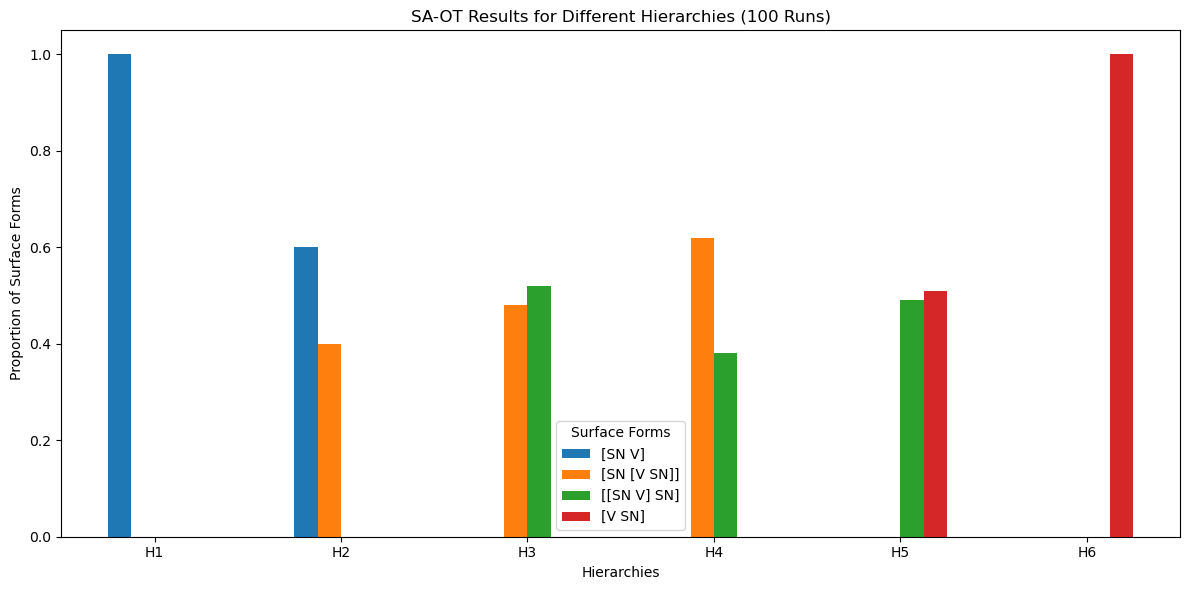

In [10]:
# ----- Analyzing results -----
def analyze_results(results, pretty=True, flat=False):
    """Analyze results from SA-OT runs: counts and proportions of surface forms.
    
    Args:        
        results (dict): Dictionary with hierarchy names as keys and lists of surface forms as values.
        pretty (bool): If True, serialize surface forms to strings for better readability.
        flat (bool): If True, flatten the surface forms to a list of strings.   
        
    Returns:
        tuple: DataFrames with counts and proportions of surface forms per hierarchy.
    """    
    if pretty:
        # Flatten the sf's in the production history to a list of surface forms
        results = {h_name: [serialize_sf(sf, flat=flat) for sf in sfs]
                    for h_name, sfs in results.items()}
    elif flat:
        # Flatten the sf structures
        results = {h_name: [flatten_sf(sf) for sf in sfs]
                    for h_name, sfs in results.items()}
    else:
        # Keep the original nested structure of surface forms, converting them to strings for hashing
        results = {h_name: [str(sf) for sf in sfs]
                    for h_name, sfs in results.items()}
    
    # Convert production history dict to DataFrame
    results_df = pd.DataFrame(results)  # rows: runs, columns: hierarchies, cells: surface forms
    sf_order = sorted(set(results_df.values.ravel()), key=lambda sf: sf.replace('[', '').replace(']', ''))  # Sort surface forms to match expected order given hierarchies
    
    # Count the occurrences of each surface form per generation 
    counts = results_df.apply(lambda x: x.value_counts()).fillna(0)
    # Reorder rows (i.e., surface forms) in counts according to sf_order
    counts = counts.loc[sf_order]

    # Convert counts to proportions
    proportions = counts.apply(lambda x: x / x.sum(), axis=0) 
    
    return counts, proportions


# ----- Visualizing results -----
counts_df, proportions_df = analyze_results(results, pretty=True, flat=False)
display(counts_df)
display(proportions_df)

# Plotting the results
plt.figure(figsize=(12, 6))
proportions_df.T.plot(kind='bar', figsize=(12, 6))
plt.title(f'SA-OT Results for Different Hierarchies ({n} Runs)')
plt.xlabel('Hierarchies')
plt.ylabel('Proportion of Surface Forms')
plt.xticks(rotation=0)
plt.legend(title='Surface Forms')
plt.tight_layout()
plt.show()

## Different constraint K-values

Hierarchies 2 and 5 introduce both a global optimum (preverbal negation [SN V] and postverbal negation [V SN], respectively) and a local optimum (the forms of discontinuous negation [SN [V SN]] and [[SN V] SN], repsectively). Simulated annealing applied to these hierarchies produces the global optimum (the "grammatical form") with frequency `p`, and the other local optimum (the "performance errors") with frequency `1 − p`. Thus, `p` is the precision of SA-OT: the probability of finding the grammatical form. The value of this probability depends on the parameters of the algorithm. While `K_max` and `t_step` seem to have minimal impact according to Lopopolo and Biro, the athours find that reducing the ranking value of the lowest-ranked constraint makes the value of `p` vary from a bit over 0.5 to almost 1.0. This is what we test below. Note that from the point of view of traditional OT, decreasing the rank of the lowest ranked constraint does not change the grammar since the order of the constraints remains the same, and the harmony of the candidates are also unaffected. 

In [11]:
k_values_last = [i for i in range(1, -11, -1)]

all_results = {}

for k in k_values_last:
    n = 100  # Number of runs for each hierarchy
    print(f"Running {n} SA-OT simulations for k={k}...")
    k_values = np.array([4, 3, 2, k])
    results = sa_ot_multiple_runs(initial_sf='V', hierarchies=HIERARCHIES_DICT, k_values=k_values, n=n, verbose=False)

    # Count surface forms and compute proportions
    _, results_proportions = analyze_results(results, pretty=True, flat=True)

    # Convert proportions to DataFrame
    all_results[k] = pd.DataFrame(results_proportions).fillna(0) 

Running 100 SA-OT simulations for k=1...
Running 100 SA-OT simulations for k=0...
Running 100 SA-OT simulations for k=-1...
Running 100 SA-OT simulations for k=-2...
Running 100 SA-OT simulations for k=-3...
Running 100 SA-OT simulations for k=-4...
Running 100 SA-OT simulations for k=-5...
Running 100 SA-OT simulations for k=-6...
Running 100 SA-OT simulations for k=-7...
Running 100 SA-OT simulations for k=-8...
Running 100 SA-OT simulations for k=-9...
Running 100 SA-OT simulations for k=-10...


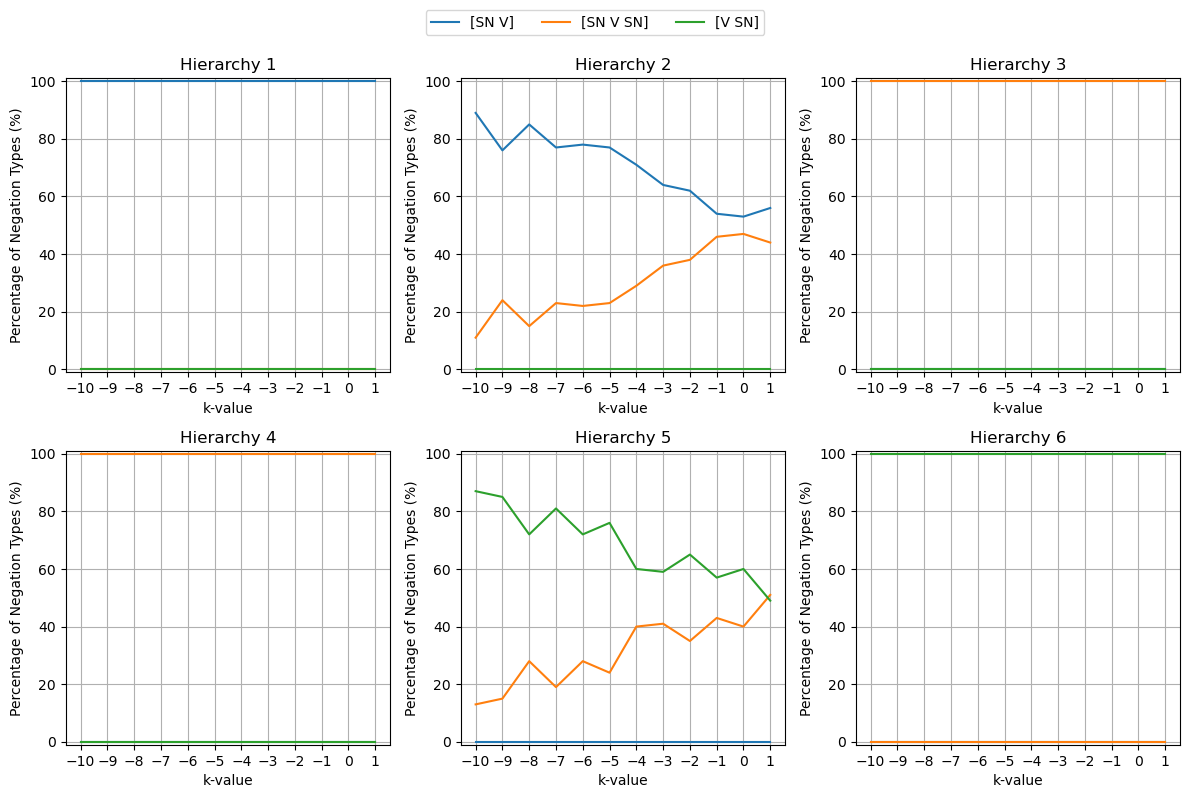

In [12]:
# ----- Plotting the results for each hierarchy across k-values -----

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Go through each hierarchy and plot surface form proportions across k-values
for ax, (h_name, _) in zip(axes.flat, HIERARCHIES_DICT.items()):
    # Build a DataFrame: rows are k-values, columns are prettified surface forms
    df = pd.DataFrame({
        k: all_results[k][h_name] if h_name in all_results[k] else pd.Series()
        for k in k_values_last
    }).T.fillna(0)

    for sf in df.columns:
        ax.plot(k_values_last, df[sf] * 100, label=sf)

    ax.set_title(f'Hierarchy {h_name[-1]}')  # \n{">>".join(c.__name__ for c in HIERARCHIES_DICT[h_name])}
    ax.set_xlabel('k-value')
    ax.set_ylabel('Percentage of Negation Types (%)')
    ax.set_xticks(k_values_last)
    ax.set_ylim(-1, 101)
    ax.grid(True)

# Create legend from last processed df (assuming all dfs share same surface forms)
fig.legend(labels=df.columns, loc='upper center', ncol=len(df.columns), bbox_to_anchor=(0.5, 1.05))
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


# Exp.2: ABM to Simulate Transition Between Stages

The frequencies of the different forms seem to be directly related to the ranking values of the constraints. This makes it possible to learn from data with specific frequencies. 

This in turns allows to reproduce the change in dominant grammar on a population level across generations through an **iterated learning simulation** (Kirby & Hurford, 2002) where agents learn from the productions of the immediately preceding generation. 

## GLA

The iterated leaning simulation uses the **Gradual Learning Algoritm** (Boersma, 1997) to model the learning procedure. It works as follows:
When the learner's prediction differs from the observed target, the ranking values of the constraints in the learner's grammar are updated by:
- **increasing** the ranking of constraints that favor the target form, and
- **decreasing** the ranking of constraints that favor the learner's erroneous form.

In [13]:
def gla_update(grammar, predicted_sf, observed_sf, plasticity=0.1, update_ceiling=True):
    """
    Performs a single GLA update step.
    The goal is to update the K-values of the constraints in the grammar 
    such that its prediction better matches a target surface form. 

    Args:
        grammar (dict): Mapping of constraints to their ranking values {constraint_function: float}
        predicted_sf (list): predicted surface form (nested or not)
        observed_sf (list): observed surface form (nested or not)
        plasticity (float): learning rate
        update_ceiling (bool): whether to ensure ranks do not exceed a ceiling value of the highest k-value

    Returns:
        dict: updated ranks (same structure as input)
    """
    if predicted_sf == observed_sf:
        return grammar  # No update needed if predicted and observed are the same
    
    updated_grammar = grammar.copy()
    
    if update_ceiling:
        # Ensure k-values do not exceed a ceiling value of the highest k-value in the initial grammar
        max_k = max(grammar.values()) 
    
    for constraint_fn in grammar:
        # Calculate the difference in violation scores for the constraint
        predicted_violations = constraint_fn(predicted_sf)
        observed_violations = constraint_fn(observed_sf)
        diff = observed_violations - predicted_violations

        # If both violation scores are equal, no update is needed
        if diff == 0:
            continue
        # If constraint favors prediction, decrease its k-value by one step (target has lower violation score than prediction)
        if diff > 0:
            updated_grammar[constraint_fn] -= plasticity
        # If constraint favors target, increase its k-value by one step 
        else:
            updated_grammar[constraint_fn] += plasticity 
            # If applicable, ensure the new k-value does not exceed the ceiling value
            if update_ceiling and updated_grammar[constraint_fn] >= max_k:
                excessive_k = updated_grammar[constraint_fn]
                updated_grammar[constraint_fn] = max_k - 1e-9  # Set to just below the ceiling value
                print(f"WARNING: Rank of {constraint_fn.__name__} exceeded ceiling value of {max_k} ({excessive_k}) -> set to {max_k - 1e-9}.")

    return updated_grammar


# ----- Utility functions -----
def grammar_dict_to_readable(grammar_dict):
    """Convert dict with function keys to dict with function name keys for display."""
    return {fn.__name__: k for fn, k in grammar_dict.items()}


def get_hierarchy_name(grammar):
    """Get the name of the current hierarchy based on the grammar."""
    sorted_grammar = sorted(grammar.items(), key=lambda x: x[1], reverse=True)
    sorted_constraints = [constraint for constraint, _ in sorted_grammar]
    
    for h_name, constraints in HIERARCHIES_DICT.items():
        if constraints == sorted_constraints:
            return h_name
    return "Unknown hierarchy"
# ---------------------------------


# ----- Example usage of GLA update -----
grammar = {faith_neg: 4.0, star_neg: 3.0, neg_first: 2.0, neg_last: 1.0}

print(f"Initial grammar:\t{grammar_dict_to_readable(grammar)}")
h_name = get_hierarchy_name(grammar)
hierarchy = HIERARCHIES_DICT[h_name]
k_values = [grammar[c] for c in hierarchy]
hierarchy_formatted = " >> ".join(c.__name__ for c in hierarchy)
print(f"\t   Hierarchy {h_name[-1]}: {hierarchy_formatted}\n\t      K-values: {k_values}")

for id in range(5):  # multiple updates
    grammar_updated = gla_update(
        grammar,
        predicted_sf=['SN', 'V'],
        observed_sf=['V', 'SN']
    )
    grammar = grammar_updated 
    print(f"\nGrammar after update {id + 1}: {grammar_dict_to_readable(grammar)}")
    h_name = get_hierarchy_name(grammar)
    hierarchy = HIERARCHIES_DICT[h_name]
    k_values = [grammar[c] for c in hierarchy]
    hierarchy_formatted = " >> ".join(c.__name__ for c in hierarchy)
    print(f"\t   Hierarchy {h_name[-1]}: {hierarchy_formatted}\n\t      K-values: {k_values}")

Initial grammar:	{'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 2.0, 'neg_last': 1.0}
	   Hierarchy 1: faith_neg >> star_neg >> neg_first >> neg_last
	      K-values: [4.0, 3.0, 2.0, 1.0]

Grammar after update 1: {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.9, 'neg_last': 1.1}
	   Hierarchy 1: faith_neg >> star_neg >> neg_first >> neg_last
	      K-values: [4.0, 3.0, 1.9, 1.1]

Grammar after update 2: {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.7999999999999998, 'neg_last': 1.2000000000000002}
	   Hierarchy 1: faith_neg >> star_neg >> neg_first >> neg_last
	      K-values: [4.0, 3.0, 1.7999999999999998, 1.2000000000000002]

Grammar after update 3: {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.6999999999999997, 'neg_last': 1.3000000000000003}
	   Hierarchy 1: faith_neg >> star_neg >> neg_first >> neg_last
	      K-values: [4.0, 3.0, 1.6999999999999997, 1.3000000000000003]

Grammar after update 4: {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.5999999999999996, 'n

## Agent Class

In [14]:
class SAOTAgent:
    def __init__(self, id, hierarchy_name, k_values):
        """An agent equipped with:
        - an OT grammar (the model of its competence): A set of constraints with associated K-values. 
                                                        The agent's grammar is initialized with random K-values between -0.1 and 4.9 
                                                        for the constraints in the order of the specified hierarchy 
                                                        (only the Faith[Neg] constraint is always initialized with a K-value of 4.9).
        - an SA-OT production procedure (performance): The agent can produce surface forms based on its grammar.
        - a GLA learning procedure (Boersma, 1997): The agent can update its grammat based on observed surface forms. 
        
        Args:
            id (int): Unique identifier for the agent.
            hierarchy_name (str): Name of the hierarchy to initialize the agent's grammar.
            k_values (list or str): List of 4 K-values for the constraints in the hierarchy, or string choosing a predefined list. 
                                    If 'random', uses random values between -0.1 and 4.9 (except for Faith[Neg] which is always initialized with 4.9).
                                    If 'default', uses the default K-values [4, 3, 2, 1].
        """
        
        self.id = id

        self.HIERARCHIES_DICT = {
            "H1": [faith_neg, star_neg, neg_first, neg_last],
            "H2": [faith_neg, neg_first, star_neg, neg_last],
            "H3": [faith_neg, neg_first, neg_last, star_neg],
            "H4": [faith_neg, neg_last, neg_first, star_neg],
            "H5": [faith_neg, neg_last, star_neg, neg_first],
            "H6": [faith_neg, star_neg, neg_last, neg_first]
        }
        
        self.global_optima = {
            "H1": ['SN', 'V'],
            "H2": ['SN', 'V'],
            "H3": ['SN', 'V', 'SN'],
            "H4": ['SN', 'V', 'SN'],
            "H5": ['V', 'SN'],
            "H6": ['V', 'SN']
        }
        
        self.local_optima_produced = {h: [] for h in self.HIERARCHIES_DICT.keys()}

        # Initialize the k-values of the constraints
        if k_values == 'random':
            # Initialize K-values of markedness constraints randomly, only faithfulness constraint Faith[Neg] always has K=4.9
            self.k_values = sorted([4.9] + [random.uniform(-0.1, 4.9) for _ in range(3)], reverse=True)
        elif k_values == 'default':
            # Use the default K-values [4, 3, 2, 1]
            self.k_values = K_VALUES_DEFAULT
        else:
            # Use custom K-values
            assert isinstance(k_values, list) and len(k_values) == 4, "k_values must be a list of 4 K-values."
            self.k_values = k_values
        
        # Record the chosen hierarchy
        self.initial_hierarchy_name = hierarchy_name 
        
        # Initialize agent's grammar with the specified hierarchy and k-values scheme
        self.grammar = self.init_grammar()

    def __repr__(self):
        """String representation of the agent."""
        return f"Agent(id={self.id}, hierarchy={self.hierarchy_name}, grammar={self.grammar_dict_to_readable(self.grammar)})"

    def init_grammar(self):
        """Initialize the agent's grammar based on the specified hierarchy."""
        assert self.initial_hierarchy_name in self.HIERARCHIES_DICT, f"Invalid hierarchy name: {self.initial_hierarchy_name}"
        
        init_k_values = self.k_values.copy()
        grammar = {constraint: k for constraint, k in 
                        zip(self.HIERARCHIES_DICT[self.initial_hierarchy_name], init_k_values)}
        return grammar

    def grammar_dict_to_readable(self, grammar_dict):
        """Convert dict with function keys to dict with function name keys for display."""
        return {fn.__name__: rank for fn, rank in grammar_dict.items()}

    @property
    def hierarchy_name(self):
        """Dynamic property that returns current hierarchy name."""
        sorted_grammar = sorted(self.grammar.items(), key=lambda x: x[1], reverse=True)
        sorted_constraints = [constraint for constraint, _ in sorted_grammar]
        
        for h_name, h_constraints in self.HIERARCHIES_DICT.items():
            if h_constraints == sorted_constraints:
                return h_name
        return f"Unknown hierarchy: {self.grammar_dict_to_readable(self.grammar)}"
    
    def produce_sf(self):
        """Produce a surface form based on the agent's grammar."""        
        # Run SA-OT with current grammar state
        return sa_ot(initial_sf='V',
                     grammar=self.grammar,
                     K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50)
    
    def learn_from(self, observed_sf, plasticity=0.1, verbose=False):
        """Update the agent's grammar based on observed surface form."""
        # Predict surface form using SA-OT with current grammar state
        predicted_sf = self.produce_sf()
        if verbose:
            print(f"Agent {self.id} learning based on predicted surface form: {serialize_sf(predicted_sf, flat=True)}")
            
        # Check if the predicted surface form matches the global optimum for the current hierarchy
        if serialize_sf(predicted_sf, flat=True) != serialize_sf(self.global_optima[self.hierarchy_name], flat=True):
            self.local_optima_produced[self.hierarchy_name].append(serialize_sf(predicted_sf, flat=True))
        
        # Update grammar based on comparison of predicted and observed sf
        updated_grammar = gla_update(grammar=self.grammar, predicted_sf=predicted_sf, observed_sf=observed_sf, plasticity=plasticity)
        self.grammar = updated_grammar


# ----- Example usage of Agent -----
adult_agent = SAOTAgent(id=0, hierarchy_name='H1', k_values='random')
print(f"Initial agent:\n\t{adult_agent}")

new_agent = SAOTAgent(id=1, hierarchy_name='H6', k_values='random')

iter = 0
while new_agent.hierarchy_name != adult_agent.hierarchy_name:
    iter += 1
    target_sf = adult_agent.produce_sf()  # Adult agent produces a surface form based on the current grammar
    print(f"\nNew agent is learning from target surface form: {serialize_sf(target_sf, flat=True)}...")
    new_agent.learn_from(target_sf) 
    print(f"New gent after learning iteration {iter}:\n\t{new_agent}")

Initial agent:
	Agent(id=0, hierarchy=H1, grammar={'faith_neg': 4.9, 'star_neg': 4.244258848710149, 'neg_first': 2.1921283295699383, 'neg_last': 0.5119025406322104})

New agent is learning from target surface form: [SN V]...
New gent after learning iteration 1:
	Agent(id=1, hierarchy=H6, grammar={'faith_neg': 4.9, 'star_neg': 4.549975290336336, 'neg_last': 4.079368625193925, 'neg_first': 1.803533421411273})

New agent is learning from target surface form: [SN V]...
New gent after learning iteration 2:
	Agent(id=1, hierarchy=H6, grammar={'faith_neg': 4.9, 'star_neg': 4.549975290336336, 'neg_last': 3.9793686251939246, 'neg_first': 1.9035334214112731})

New agent is learning from target surface form: [SN V]...
New gent after learning iteration 3:
	Agent(id=1, hierarchy=H6, grammar={'faith_neg': 4.9, 'star_neg': 4.549975290336336, 'neg_last': 3.8793686251939246, 'neg_first': 2.003533421411273})

New agent is learning from target surface form: [SN V]...
New gent after learning iteration 4:


### Convergence Test

Convergence test simulating  SA-OT with iterated learning to measure how quickly new learner agents born with different grammars adopt the grammar of a teacher (adult) agent. The goal is to understand how stable a target grammar is (in this case, Hierarchy 1) under transmission through GLA-based learning. We analyze:
- How many learning iterations are needed for agents starting from different grammars to converge to H1.
- How consistent that convergence is across multiple independent simulations.
- Whether certain starting grammars (e.g., H2 vs. H6) make convergence easier or harder. 

In [ ]:
def run_convergence_test(n_runs=100, max_iters=300, k_values='default', verbose=False):
    """
    Runs SA-OT convergence tests simulating learning from an adult agent (H1) by learners
    starting with different grammars (H2 to H6).
    
    Args:
        n_runs (int): Number of independent simulation runs per starting grammar.
        max_iters (int): Maximum learning iterations per agent.
        k_values (str or list): Initial K-values for all agents, including adult.
        verbose (bool): Whether to print detailed output.
        
    Returns:
        all_learning_iters (np.ndarray): Convergence iteration counts (n_runs x 5 for H2-H6).
    """

    hierarchies = list(range(2, 7))  # H2 to H6
    n_agents = len(hierarchies)
    conv_iters_matrix = np.zeros((n_runs, n_agents))
    
    local_optima_per_run = []

    for run in range(n_runs):        
        if run % 10 == 0:
            print(f"Run {run + 1}/{n_runs}...")

        # Initialize the adult agent with the specified hierarchy and k-values
        adult_agent = SAOTAgent(id=0, hierarchy_name='H1', k_values=k_values)
        if verbose:
            print(f"Adult agent (H1): {adult_agent}")

        # Initialize a dictionary to store local optima produced by each agent while learning
        local_optima = {}

        # Iterate over hierarchies, creating a new agent for each
        for j, h in enumerate(hierarchies):
            # Create a new agent with the current hierarchy
            new_agent = SAOTAgent(id=h, hierarchy_name=f'H{h}', k_values=k_values)
            if verbose:
                print(f"\nNew agent (H{h}): {new_agent}")
            count = 0

            # The new agent learns from the adult agent until it converges to the same hierarchy
            while new_agent.hierarchy_name != adult_agent.hierarchy_name:
                if count > max_iters:
                    conv_iters_matrix[run, j] = np.nan  # did not converge
                    print(f"  At run {run+1} agent {new_agent.initial_hierarchy_name} did not converge after {max_iters} iterations.")
                    break
                count += 1
                observed_sf = adult_agent.produce_sf()
                new_agent.learn_from(observed_sf, verbose=False)
                if verbose:
                    print(f"Agent {new_agent.initial_hierarchy_name} after update {count}: {new_agent}")
            
            local_optima[f'Agent {new_agent.initial_hierarchy_name}'] = new_agent.local_optima_produced
            
            if verbose:
                print(f"Agent {new_agent.initial_hierarchy_name} settled on {new_agent.hierarchy_name} after {count} iterations.")
                print(f"Local optima produced: {new_agent.local_optima_produced}")

            if count <= max_iters:
                conv_iters_matrix[run, j] = count
        
        local_optima_per_run.append(local_optima)
        
    return conv_iters_matrix, local_optima_per_run

In [16]:
n_runs = 100
hierarchies = list(range(2, 7))  # H2 to H6
labels = [f'H{h}' for h in hierarchies]

# Run simulations
print(f"Running convergence test with default k-values...")
conv_iters_matrix_default, local_optima_per_run_default = run_convergence_test(n_runs=n_runs, max_iters=300, k_values='default', verbose=False)
print(f"\nRunning convergence test with random float k-values...")
conv_iters_matrix_random, local_optima_per_run_random = run_convergence_test(n_runs=n_runs, max_iters=300, k_values='random', verbose=False)

assert conv_iters_matrix_default.shape == (n_runs, len(hierarchies)), "Shape mismatch for default K-values."
assert conv_iters_matrix_random.shape == (n_runs, len(hierarchies)), "Shape mismatch for random K-values."

Running convergence test with default k-values...
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...

Running convergence test with random float k-values...
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...


C:\Users\Raya\AppData\Local\Temp\ipykernel_34748\1166594189.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(


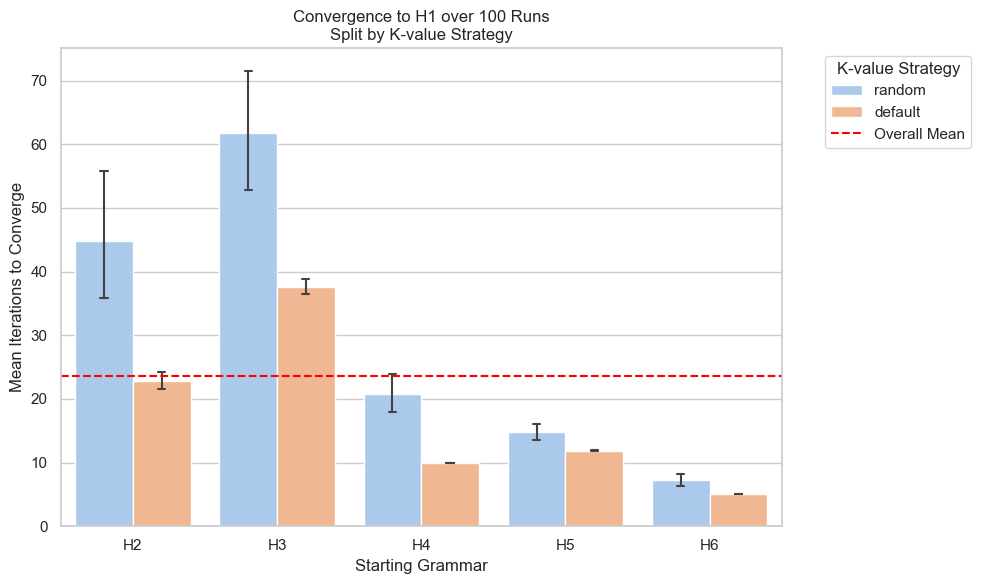

In [17]:
# Create combined DataFrame
data = []

for run_idx in range(n_runs):
    for agent_idx, h in enumerate(hierarchies):
        data.append({
            'start_hierarchy': f'H{h}',
            'iterations': conv_iters_matrix_random[run_idx, agent_idx],
            'strategy': 'random'
        })
        data.append({
            'start_hierarchy': f'H{h}',
            'iterations': conv_iters_matrix_default[run_idx, agent_idx],
            'strategy': 'default'
        })

df = pd.DataFrame(data)


# ----- Barplot -----
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Barplot with automatic CI (95% by default)
ax = sns.barplot(
    data=df,
    x='start_hierarchy',
    y='iterations',
    hue='strategy',
    capsize=0.1,
    errwidth=1.5,
    errorbar='ci',  
    palette='pastel'
)

# Add global mean line
global_mean = df['iterations'].mean()
plt.axhline(global_mean, linestyle='--', color='red', label='Overall Mean')

plt.xlabel('Starting Grammar')
plt.ylabel('Mean Iterations to Converge')
plt.title(f'Convergence to H1 over {n_runs} Runs\nSplit by K-value Strategy')
plt.legend(title='K-value Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Agents' initial grammar seems to have a large effect on their learning rate given H1-generated learning data.

,start_hierarchy,iterations,strategy
0,H2,18.0,default
1,H2,93.0,random
2,H3,39.0,default
3,H3,13.0,random
4,H4,10.0,default


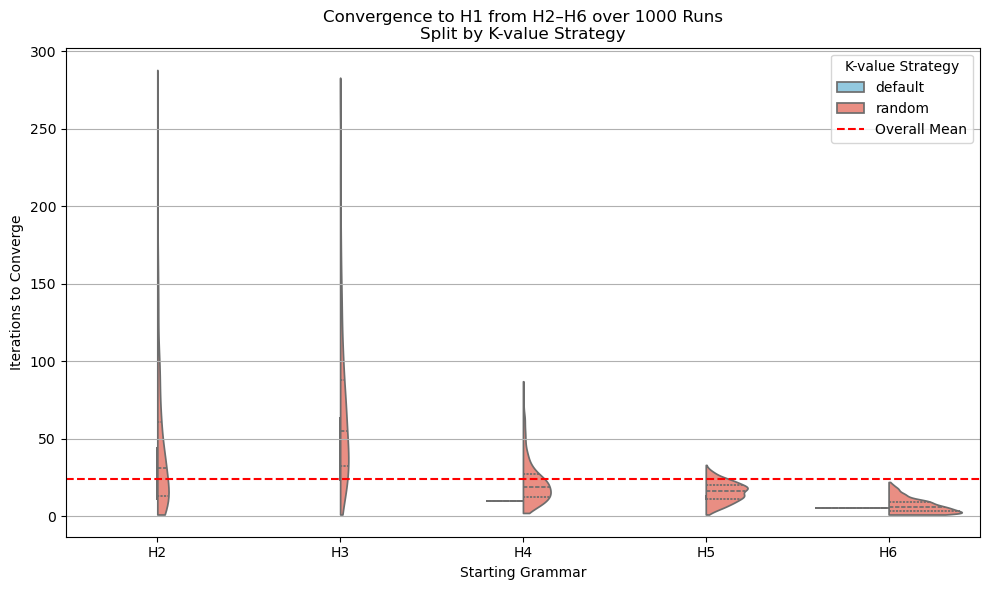

In [130]:
# ----- Violin plot -----

# Combine results into one dataframe
data = []

for run_idx in range(n_runs):
    for agent_idx, h in enumerate(hierarchies):
        # Default strategy
        data.append({
            'start_hierarchy': f'H{h}',
            'iterations': conv_iters_matrix_default[run_idx, agent_idx],
            'strategy': 'default'
        })
        # Random strategy
        data.append({
            'start_hierarchy': f'H{h}',
            'iterations': conv_iters_matrix_random[run_idx, agent_idx],
            'strategy': 'random'
        })

df = pd.DataFrame(data)
display(df.head())


# ----- Plot violins -----
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=df,
    x='start_hierarchy',
    y='iterations',
    hue='strategy',
    split=True,
    inner='quartile',
    cut=0,
    palette={'default':'skyblue', 'random':'salmon'},
)

plt.axhline(df['iterations'].mean(), linestyle='--', color='red', label='Overall Mean')

plt.title(f'Convergence to H1 from H2–H6 over {n_runs} Runs\nSplit by K-value Strategy')
plt.xlabel("Starting Grammar")
plt.ylabel("Iterations to Converge")
plt.grid(axis='y')
plt.legend(title="K-value Strategy")
plt.tight_layout()
plt.show()


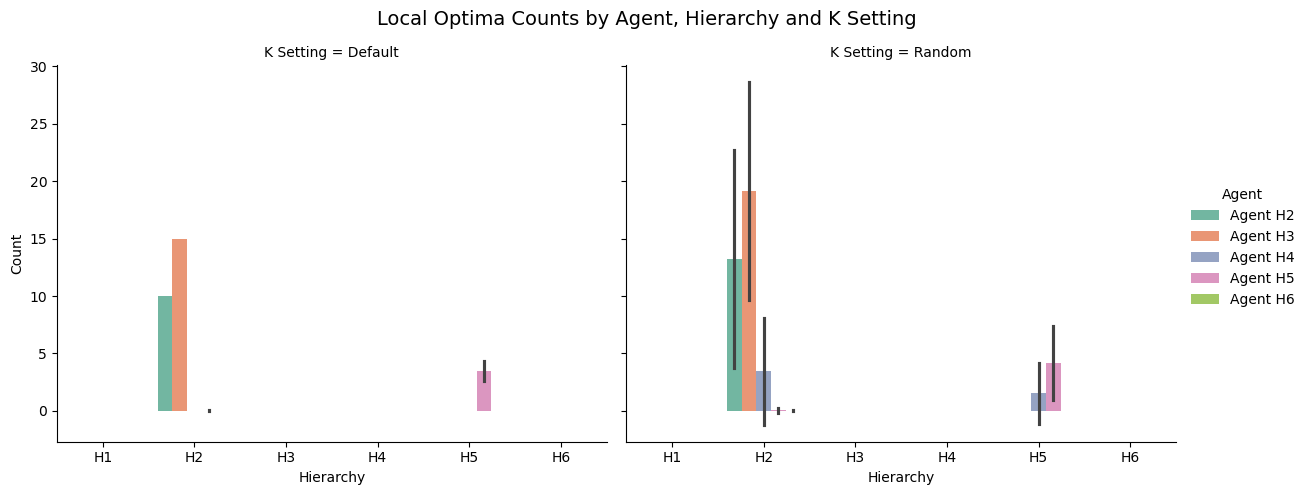

In [131]:
from collections import defaultdict

def aggregate_local_optima_stats(local_optima_per_run):
    """Aggregare counts of local optima produced by agents across runs.
    
    Args:
        local_optima_per_run (list): List of dictionaries with local optima per agent per run.
        
    Returns:
        dict: Dictionary with agent names as keys and their local optima counts as values.
    """
    # Initialize nested dict: agent -> hierarchy -> list of counts
    aggregate_counts = defaultdict(lambda: defaultdict(list))
    
    # Accumulate counts for each agent and hierarchy across runs
    for run in local_optima_per_run:
        for agent, optima_dict in run.items():
            for h, opt in optima_dict.items():
                aggregate_counts[agent][h].append(len(opt))
    
    return aggregate_counts


def local_optima_stats(local_optima_per_run):
    """Compute mean counts and standard deviations of local optima produced by agents.
    
    Args:
        local_optima_per_run (list): List of dictionaries with local optima per agent per run.
        
    Returns:
        pd.DataFrame: DataFrame with mean counts and standard deviations of local optima per agent.
    """
    aggregate_counts = aggregate_local_optima_stats(local_optima_per_run)
    
    # Prepare data for DataFrame
    data = []
    for agent, hierarchies in aggregate_counts.items():
        for h, counts in hierarchies.items():
            mean_count = np.mean(counts)
            std_count = np.std(counts)
            data.append({
                'Agent': agent,
                'Hierarchy': h,
                'Mean Count': mean_count,
                'Std Dev': std_count
            })
    
    return pd.DataFrame(data)


def aggregate_counts_to_long_df(aggregate_counts, k_setting_name=None):
    """
    Convert aggregated counts dict to long-form DataFrame for seaborn plotting.
    
    Args:
        aggregate_counts (dict): nested dict as returned by aggregate_local_optima_stats
        k_setting_name (str, optional): Label for the K setting condition, if any.
        
    Returns:
        pd.DataFrame: with columns ['Agent', 'Hierarchy', 'Count', 'K Setting']
    """
    rows = []
    for agent, hierarchies in aggregate_counts.items():
        for hierarchy, counts in hierarchies.items():
            for count in counts:
                row = {
                    'Agent': agent,
                    'Hierarchy': hierarchy,
                    'Count': count
                }
                if k_setting_name is not None:
                    row['K Setting'] = k_setting_name
                rows.append(row)
    df = pd.DataFrame(rows)
    if 'K Setting' not in df.columns:
        df['K Setting'] = 'Unknown'  # default label if none provided
    return df



# Aggregate raw counts (nested dicts)
agg_default = aggregate_local_optima_stats(local_optima_per_run_default)
agg_random = aggregate_local_optima_stats(local_optima_per_run_random)

# Convert to long DataFrames with a label for each K setting
df_default = aggregate_counts_to_long_df(agg_default, k_setting_name="Default")
df_random = aggregate_counts_to_long_df(agg_random, k_setting_name="Random")

# Combine both conditions into a single DataFrame
df_all = pd.concat([df_default, df_random], ignore_index=True)

sns.catplot(
    data=df_all,
    kind='bar',
    x='Hierarchy',
    y='Count',
    hue='Agent',
    col='K Setting',
    errorbar='sd',    
    palette='Set2',
    dodge=True,
    height=5,
    aspect=1.2
)

plt.suptitle("Local Optima Counts by Agent, Hierarchy and K Setting", fontsize=14)
plt.subplots_adjust(top=0.87)  

plt.show()

As expected, lcoal optima are only produced with hierarchies representing mixed stages (H2 and H5). 

In [ ]:
def convergence_test_productions(learning_iters=30, production_sample=100, observed_sf = ['SN', 'V'], k_values='default', verbose=False):
    """
    Runs SA-OT convergence tests simulating learning from an adult agent (H1) by learners
    starting with different grammars (H2 to H6).
    
    Args:
        n_runs (int): Number of independent simulation runs per starting grammar.
        learning_iters (int): Number of learning iterations per agent.
        k_values (str or list): Initial K-values for all agents, including adult.
        verbose (bool): Whether to print detailed output.
        
    Returns:
    """

    hierarchies = list(range(2, 7))  # H2 to H6
    n_agents = len(hierarchies)

    production_history = {f'H{h}': [] for h in hierarchies}
    
    # Iterate over hierarchies, creating a new agent for each
    for j, h in enumerate(hierarchies):
        # Create a new agent with the current hierarchy
        new_agent = SAOTAgent(id=h, hierarchy_name=f'H{h}', k_values=k_values)
        if verbose:
            print(f"\nNew agent (H{h}): {new_agent}")

        # The new agent goes through the specified number of learning iterations
        for i in range(learning_iters):
            new_agent.learn_from(observed_sf, verbose=False)
            if verbose:
                print(f"Agent {new_agent.initial_hierarchy_name} after update {i+1}: {new_agent}")
        
        # Record productions for the current agent
        for _ in range(production_sample):
            produced_sf = new_agent.produce_sf()          
            production_history[f'H{h}'].append(serialize_sf(produced_sf, flat=True))
    
    return production_history


def run_multiple_convergence_tests(n_runs=10, learning_iters=30, production_sample=100, observed_sf=['SN', 'V'], k_values='default', verbose=False):
    all_counts = []

    for run in range(n_runs):
        if verbose or run % 10 == 0:
            print(f"\n--- Run {run+1} ---")

        production_history = convergence_test_productions(
            learning_iters=learning_iters, 
            production_sample=production_sample, 
            observed_sf=observed_sf, 
            k_values=k_values, 
            verbose=verbose
        )

        # Convert to DataFrame
        production_df = pd.DataFrame(production_history).melt(var_name='Initial Hierarchy', value_name='Surface Form')
        
        # Count occurrences of each surface form per hierarchy
        surface_form_counts = (
            production_df.groupby(['Initial Hierarchy', 'Surface Form'])
            .size()
            .reset_index(name='Count')
        )
        surface_form_counts['Run'] = run
        all_counts.append(surface_form_counts)

    return pd.concat(all_counts, ignore_index=True)

# Example usage
stats = run_multiple_convergence_tests(n_runs=10, learning_iters=30, production_sample=100, verbose=False)
stats_display = stats.pivot_table(index='Surface Form', columns='Initial Hierarchy', values='Count', fill_value=0)
print(stats_display)


--- Run 1 ---
Initial Hierarchy     H2    H3     H4     H5     H6
Surface Form                                       
[SN V SN]            0.0  44.9    0.0    0.0    0.0
[SN V]             100.0  55.1  100.0  100.0  100.0



--- Sweeping Learning Iterations: 20 ---

--- Run 1 ---

--- Run 11 ---

--- Run 21 ---

--- Run 31 ---

--- Run 41 ---

--- Run 51 ---

--- Run 61 ---

--- Run 71 ---

--- Run 81 ---

--- Run 91 ---

--- Sweeping Learning Iterations: 25 ---

--- Run 1 ---

--- Run 11 ---

--- Run 21 ---

--- Run 31 ---

--- Run 41 ---

--- Run 51 ---

--- Run 61 ---

--- Run 71 ---

--- Run 81 ---

--- Run 91 ---

--- Sweeping Learning Iterations: 30 ---

--- Run 1 ---

--- Run 11 ---

--- Run 21 ---

--- Run 31 ---

--- Run 41 ---

--- Run 51 ---

--- Run 61 ---

--- Run 71 ---

--- Run 81 ---

--- Run 91 ---

--- Sweeping Learning Iterations: 35 ---

--- Run 1 ---

--- Run 11 ---

--- Run 21 ---

--- Run 31 ---

--- Run 41 ---

--- Run 51 ---

--- Run 61 ---

--- Run 71 ---

--- Run 81 ---

--- Run 91 ---

--- Sweeping Learning Iterations: 40 ---

--- Run 1 ---

--- Run 11 ---

--- Run 21 ---

--- Run 31 ---

--- Run 41 ---

--- Run 51 ---

--- Run 61 ---

--- Run 71 ---

--- Run 81 ---

--- Run 91

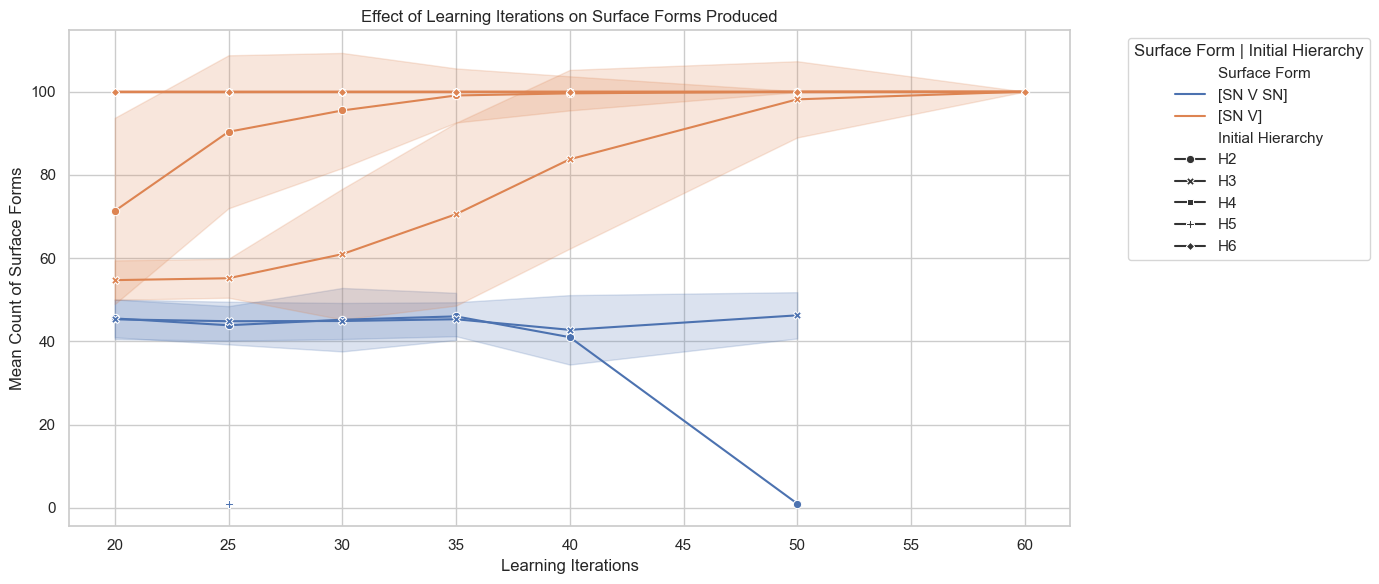

In [161]:
def sweep_learning_iters(iters_list, n_runs=10, production_sample=100, observed_sf=['SN', 'V'], k_values='default'):
    sweep_results = []

    for iters in iters_list:
        print(f"\n--- Sweeping Learning Iterations: {iters} ---")
        run_df = run_multiple_convergence_tests(
            n_runs=n_runs,
            learning_iters=iters,
            production_sample=production_sample,
            observed_sf=observed_sf,
            k_values=k_values,
            verbose=False
        )
        run_df['Learning Iters'] = iters
        sweep_results.append(run_df)

    return pd.concat(sweep_results, ignore_index=True)


def plot_surface_form_evolution(df):
    plt.figure(figsize=(14, 6))
    sns.set(style="whitegrid")

    ax = sns.lineplot(
        data=df,
        x='Learning Iters',
        y='Count',
        hue='Surface Form',              # Color by Surface Form
        style='Initial Hierarchy',       # Marker by Initial Hierarchy
        markers=True,
        dashes=False,
        err_style="band",                # Confidence interval as band
        errorbar='sd',                   # Use standard deviation for error bands
        estimator='mean'                 # Plot the mean over runs
    )

    plt.title('Effect of Learning Iterations on Surface Forms Produced')
    plt.ylabel('Mean Count of Surface Forms')
    plt.xlabel('Learning Iterations')
    plt.legend(title='Surface Form | Initial Hierarchy', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# Define the list of learning iterations to sweep
learning_iters_list = [20, 25, 30, 35, 40, 50, 60]
sweep_df = sweep_learning_iters(learning_iters_list, n_runs=100, production_sample=100)

# Plot with SD error bands
plot_surface_form_evolution(sweep_df)

## Model Class

In [ ]:
class SAOTModel:
    def __init__(self, pop_size=5, generations=100, 
                 gen0_hierarchy_name='H1', gen0_k_values='default',
                 k_values='random', gla_plasticity=0.1, seed=42,
                 learning_data_size=30, productions_per_agent=100):

        self.seed = seed
        if self.seed is not None:
            random.seed(self.seed)  
        
        self.pop_size = pop_size
        self.generations = generations
        self.gen0_hierarchy_name = gen0_hierarchy_name
        self.gen0_k_values = gen0_k_values
        self.k_values = k_values
        self.gla_plasticity = gla_plasticity  # Learning rate for GLA updates
        self.learning_data_size = learning_data_size
        self.productions_per_agent = productions_per_agent

        self.agents = []
        self.current_gen = 0
        
        self.production_history = {}
        self.initial_hierarchies = {}
        self.updated_hierarchies = {} 
        
        self.HIERARCHY_NAMES = [f"H{i}" for i in range(1, 7)]

    def __repr__(self):
        """String representation of the model."""
        return f"Model(seed={self.seed}, pop_size={self.pop_size}, generations={self.generations}, gen0_hierarchy={self.gen0_hierarchy_name}, k_values={self.k_values}, learning_data={self.learning_data_size}"

    def init_pop(self):
        """Initialize a population of agents with specified initial hierarchy."""  
        for i in range(-self.pop_size, 0):
            agent = SAOTAgent(i, hierarchy_name=self.gen0_hierarchy_name, k_values=self.gen0_k_values) 
            self.agents.append(agent)
    
    def step(self):
        """Perform a single step of the model (i.e., one generation):
        - create new generation of agents with randomly initialized grammars, 
        - adjust their grammars iteratively based on learning data from the previous generation, 
        - record a production sample from the new generation once learning is done,
        - replace the old generation with the new one.
        """       
        assert len(self.agents) > 0, "Population must be initialized before stepping."
        self.current_gen += 1
        
        # Initialize new agents with a randomly chosen hierarchy
        new_agents = []
        id_start = (self.current_gen-1) * len(self.agents) + 1
        for id in range(id_start, id_start + self.pop_size):
            hierarchy_name = random.choice(self.HIERARCHY_NAMES) # Randomly select a hierarchy for the new agent
            agent = SAOTAgent(id, hierarchy_name=hierarchy_name, k_values=self.k_values) 
            new_agents.append(agent)
        
        # Store initial hierarchies for this generation
        self.initial_hierarchies[self.current_gen] = [agent.hierarchy_name for agent in new_agents]
        
        # Each agent learns from (updates their grammar given) observed surface forms produced by the previous generation
        for agent in new_agents: 
            # Each agent is exposed to learning_data_size productions of the previous generation
            for _ in range(self.learning_data_size):
                # Randomly select an adult to learn from
                adult = random.choice(self.agents)
                adult_sf = adult.produce_sf()  # Adult produces a surface form
                agent.learn_from(adult_sf, self.gla_plasticity)  # Update agent's grammar based on the adult's production
        # After learning, agents in the new generation will produce surface forms based on their updated grammars

        # Store final hierarchies for this generation
        self.updated_hierarchies[self.current_gen] = [agent.hierarchy_name for agent in new_agents]

        # Record production sample from new generation with updated grammars
        production_sample = []
        for agent in new_agents:
            # Each agent produces a sample of surface forms based on its grammar
            for i in range(self.productions_per_agent):
                production = agent.produce_sf()
                production_sample.append(production)  
        assert len(production_sample) == 500, f"Production sample size is {len(production_sample)}, expected 500."
        self.production_history[self.current_gen] = production_sample

        # Replace old generation of agents with the new one
        self.agents = new_agents

    def run(self, generations=None):
        """Run the model for a specified number of generations."""
        # Initialize the preliminary generation of agents (index 0)
        self.init_pop()
        print(f"Model initialized with {self.pop_size} agents.")
        
        # Run the model for the specified number of generations
        generations = generations if generations is not None else self.generations
        for i in range(generations):
            if i % 10 == 0:
                print(f"Running generation {i+1}/{generations}...")
            self.step()
        print(f"Model run completed after {self.generations} generations.")
    

    def plot_history(self, pretty=True, flat=True):
        """Plot the evolution of productions over generations."""
        if pretty:
            # Flatten the sf's in the production history to a list of surface forms
            history = {gen: [serialize_sf(sf, flat=flat) for sf in productions]
                        for gen, productions in self.production_history.items()}
        else:
            history = {gen: [str(sf) for sf in productions]
                        for gen, productions in self.production_history.items()}
        
        # Convert production history dict to DataFrame
        history_df = pd.DataFrame(history)  # rows: surface forms, columns: generations
        # Count the occurrences of each surface form per generation 
        history_count = history_df.apply(lambda x: x.value_counts()).fillna(0)
        # Convert counts to proportions
        history_proportions = history_count.apply(lambda x: x / x.sum(), axis=0) 
        # Display the proportions of surface forms produced by agents in each generation
        display(history_proportions)

        # Plotting the results over generations 
        plt.figure(figsize=(12, 6))
        generations = history_proportions.columns 
        for sf in history_proportions.index: 
            proportions = history_proportions.loc[sf]  # Get proportions for this SF across generations
            plt.plot(generations, proportions, marker='o', label=sf, linewidth=2)

        plt.title("Evolution of Surface Forms Over Generations")
        plt.xlabel("Generation")
        plt.xticks(range(0, len(generations)+1, 10))
        plt.ylabel("Proportion")
        plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for proportions
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_hierarchies(self):
        """Plot the evolution of hierarchies over generations with lines."""
        
        initial_df = pd.DataFrame(self.initial_hierarchies)
        updated_df = pd.DataFrame(self.updated_hierarchies)
        display(initial_df)
        display(updated_df)

        # Count occurrences and convert to proportions
        initial_counts = initial_df.apply(lambda x: x.value_counts()).fillna(0)
        # initial_props = initial_counts.div(initial_counts.sum(axis=0), axis=1)

        updated_counts = updated_df.apply(lambda x: x.value_counts()).fillna(0)
        # updated_props = updated_counts.div(updated_counts.sum(axis=0), axis=1)

        # Get full set of hierarchies across both sets
        # all_hierarchies = sorted(set(initial_props.index).union(updated_props.index))
        all_hierarchies = sorted(set(initial_counts.index).union(updated_counts.index))

        # Assign a color to each hierarchy
        colors = plt.get_cmap('tab10', len(all_hierarchies))
        hierarchy_to_color = {h: colors(i) for i, h in enumerate(all_hierarchies)}

        # Plotting
        plt.figure(figsize=(14, 7))

        generations = initial_counts.columns 
        for hierarchy in all_hierarchies:
            if hierarchy in initial_counts.index:
                plt.plot(
                    generations,
                    initial_counts.loc[hierarchy],
                    linestyle='--',
                    color=hierarchy_to_color[hierarchy],
                    label=f"{hierarchy} (initial)"
                )
            if hierarchy in updated_counts.index:
                plt.plot(
                    generations,
                    updated_counts.loc[hierarchy],
                    linestyle='-',
                    color=hierarchy_to_color[hierarchy],
                    label=f"{hierarchy} (updated)"
                )

        plt.title("Evolution of Hierarchies Over Generations (Counts)")
        plt.xlabel("Generation")
        plt.ylabel("Count")
        plt.xticks(range(0, len(generations), max(1, len(generations) // 20)))
        plt.grid(True, alpha=0.3)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

In [ ]:
# ----- Example usage of the Model class -----
model = SAOTModel(pop_size=5, generations=1000, 
              gen0_hierarchy_name='H1', k_values='random',
              learning_data_size=30, productions_per_agent=100)
model.run()

Model initialized with 5 agents.
Running generation 1/1000...
Running generation 11/1000...
Running generation 21/1000...
Running generation 31/1000...
Running generation 41/1000...
Running generation 51/1000...
Running generation 61/1000...
Running generation 71/1000...
Running generation 81/1000...
Running generation 91/1000...
Running generation 101/1000...
Running generation 111/1000...
Running generation 121/1000...
Running generation 131/1000...
Running generation 141/1000...
Running generation 151/1000...
Running generation 161/1000...
Running generation 171/1000...
Running generation 181/1000...
Running generation 191/1000...
Running generation 201/1000...
Running generation 211/1000...
Running generation 221/1000...
Running generation 231/1000...
Running generation 241/1000...
Running generation 251/1000...
Running generation 261/1000...
Running generation 271/1000...
Running generation 281/1000...
Running generation 291/1000...
Running generation 301/1000...
Running generatio

,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
[SN SN SN V SN],0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.00,...,0.000,0.000,0.000,0.000,0.0,0.000,0.00,0.00,0.000,0.000
[SN V SN SN],0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.00,...,0.000,0.000,0.000,0.000,0.0,0.000,0.00,0.00,0.000,0.000
[SN V SN],0.0,0.186,0.264,0.106,0.086,0.0,0.096,0.096,0.2,0.27,...,0.092,0.214,0.168,0.286,0.4,0.494,0.68,0.89,0.504,0.268
[SN V],1.0,0.814,0.636,0.694,0.914,1.0,0.904,0.904,0.8,0.73,...,0.908,0.586,0.832,0.714,0.6,0.506,0.32,0.11,0.496,0.532
[V SN],0.0,0.000,0.100,0.200,0.000,0.0,0.000,0.000,0.0,0.00,...,0.000,0.200,0.000,0.000,0.0,0.000,0.00,0.00,0.000,0.200


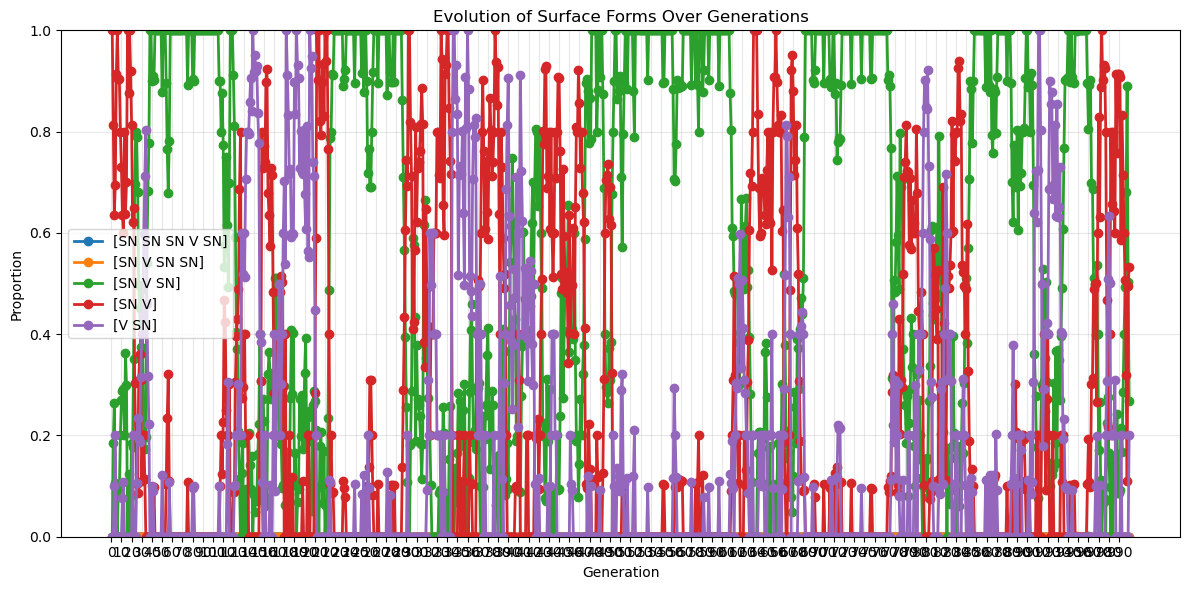

In [47]:
model.plot_history() 

## Multiple simulations

In [ ]:
import multiprocessing as mp
import time

def run_single_simulation_with_progress(args):
    """Run simulation with unpacked arguments and progress tracking."""
    sim_id, params = args
    start_time = time.time()
    
    print(f"Starting simulation {sim_id + 1}/{params['n_total']}...")
    
    model = SAOTModel(pop_size=params['pop_size'], 
                  generations=params['generations'],
                  gen0_hierarchy_name=params['gen0_hierarchy_name'],
                  learning_data_size=params['learning_data_size'],
                  productions_per_agent=params['productions_per_agent'],
                  seed=42 + sim_id)
    
    model.run()
    
    elapsed = time.time() - start_time
    print(f"Simulation {sim_id + 1} completed in {elapsed:.1f}s")
    
    return model.production_history

# ----- Parameters -----
n_simulations = 20
params = {
    'pop_size': 5,
    'generations': 100,
    'gen0_hierarchy_name': 'H1',
    'k_values': 'random',  
    'learning_data_size': 30,
    'productions_per_agent': 100,
    'n_total': n_simulations
}

# ----- Run simulations in parallel -----
if __name__ == '__main__':
    n_processes = min(n_simulations, mp.cpu_count())
    print(f"Running {n_simulations} simulations on {n_processes} processes...")
    
    # Prepare arguments for each simulation
    simulation_args = [(i, params) for i in range(n_simulations)]
    
    start_time = time.time()
    with mp.Pool(processes=n_processes) as pool:
        histories = pool.map(run_single_simulation_with_progress, simulation_args)
    
    total_time = time.time() - start_time
    print(f"All simulations completed in {total_time:.1f}s")

Mean Proportions:
[SN V SN SN]    0.0001
[SN V SN]       0.2385
[SN V]          0.5085
[V SN]          0.2529
dtype: float64


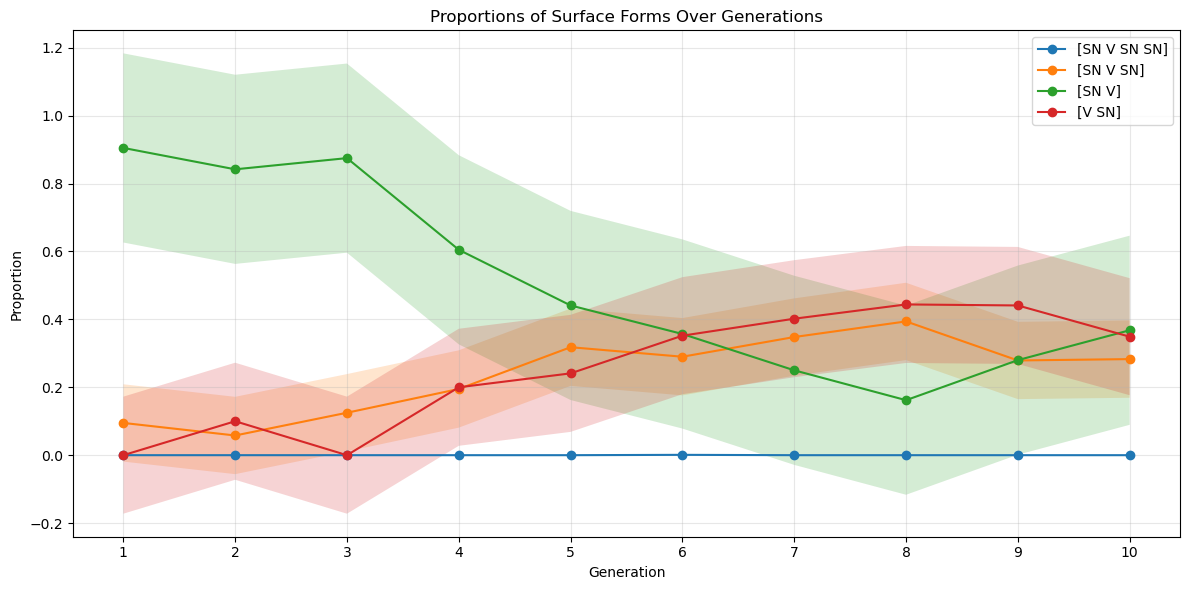

In [ ]:
# ----- Combine results -----
all_generations = {}

for history in histories:
    for gen, productions in history.items():
        if gen not in all_generations:
            all_generations[gen] = []
        all_generations[gen].extend(serialize_sf(sf, flat=True) for sf in productions)

# Convert to DataFrame
all_generations_df = pd.DataFrame(all_generations)

# Count occurrences of each surface form
counts = all_generations_df.apply(lambda x: x.value_counts()).fillna(0) 

# Convert counts to proportions
proportions = counts.apply(lambda x: x / x.sum(), axis=0)

# Calculate mean and std deviation across simulations
mean_proportions = proportions.mean(axis=1)
std_proportions = proportions.std(axis=1)

print(f"Mean Proportions:\n{mean_proportions}")

# ----- Plot aggregate results -----
plt.figure(figsize=(12, 6))

# Get generations (x-axis) from proportions columns
generations = proportions.columns
x_axis = range(len(proportions.columns))

for sf in proportions.index:  # Iterate over surface forms
    sf_proportions = proportions.loc[sf].values  # Get array of proportions across generations
    sf_mean = mean_proportions[sf]  # This is still a single value
    sf_std = std_proportions[sf]   # This is still a single value
    
    plt.plot(x_axis, sf_proportions, label=sf)
    plt.fill_between(x_axis, 
                    sf_proportions - sf_std, 
                    sf_proportions + sf_std, 
                    alpha=0.2)

plt.title("Proportions of Surface Forms Over Generations")
plt.xlabel("Generation")
plt.ylabel("Proportion")
plt.xticks(x_axis, generations)  # Label x-axis with actual generation numbers
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()